In [1]:
!pwd
import sys
sys.executable

/gpfsx01/home/aaa00162/jupyterhub/notebook/H3-057/work/scripts/test


'/home/bioinfo/.conda/envs/tfgpu_py36/bin/python'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

# ../modulesのスクリプトで multitask categorical_crossentropy test

In [3]:
import os, sys
gpu_num = 3 # "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

sys.path.append('..')
from modules import *
%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
K.clear_session()

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [5]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    print(f"y:\n{y}")
    print(f"y[0]: {y[0]}")
    plt.imshow(x[0])
    plt.show()
    return x,y

In [6]:
class Args():
    def __init__(self):
        self.img_rows = 512
        self.img_cols = 512
        self.channels = 3
        self.batch_size = 5
        self.classes = ['negative', 'positive']
        self.train_data_dir = './input/CV1_small/train'
        self.validation_data_dir = './input/CV1_small/validation'
        self.class_mode = 'categorical' # generatorのラベルをone-hotベクトルに変換する場合はこっち
        #self.class_mode='binary' # generatorのラベルを0か1のどちらかに変えるだけならこっち
        self.output_dir = 'output/multitask_categorical_crossentropy_test'
        self.trainable = 249
        self.choice_model = 'InceptionV3'
        self.activation = 'softmax'
        #self.activation = 'sigmoid'
        self.gpus = '0'
        self.is_skip_bn = True
        self.model_path = None
        self.fcs = [1024, 512, 256]
        self.drop = 0.5
        #self.is_add_batchnorm = False
        self.is_add_batchnorm = True
        self.l2_rate = 1e-4
        self.choice_optim = 'adamax'
        self.num_epoch = 5
        self.lr = 1e-4
        self.decay = 1e-6
        self.momentum = 0.9
        #self.loss = 'categorical_crossentropy'
        #self.loss = 'binary_crossentropy'
        self.loss = ['categorical_crossentropy', 'categorical_crossentropy'] # マルチタスクの場合はlossを配列で指定できる
        #self.loss = ['binary_crossentropy', 'binary_crossentropy'] # マルチタスクの場合はlossを配列で指定できる
        #self.is_multitask = False
        self.is_multitask = True
        self.multitask_pred_n_node = 2
        #self.multitask_pred_n_node = 1
        self.metrics = ['accuracy']
        #self.metrics = ['binary_accuracy']
        self.layer_name = 'mixed10'
        
        my_IDG_options={'rescale': 1.0/255.0
                        , 'width_shift_range': 0.2
                        , 'height_shift_range': 0.2
                        , 'horizontal_flip': True
                        , 'vertical_flip': True
                        , 'shear_range': 0.2
                        , 'zoom_range': 0.2
                        , 'rotation_range': 20
                        #, 'channel_shift_range': 0.0#5.
                        #, 'brightness_range': [1.0]#[0.3, 1.0]
                        , 'random_erasing_prob': 0.5
                        , 'random_erasing_maxpixel': 255
                        #, 'mix_up_alpha': 0.2 # mixup
                        #, 'random_crop': [224,224] # random_crop size
                        }
        self.my_IDG_options = my_IDG_options
        
        train_augmentor_options = {
            'input_width': 512
            , 'input_height': 512
            , 'random_dist_prob': 0.3
            , 'zoom_prob': 0.3
            , 'zoom_min': 0.5
            , 'zoom_max': 1.9
            , 'flip_left_right': 0.3
            , 'flip_top_bottom': 0.3
            , 'random_erasing_prob': 0.3
            , 'random_erasing_area': 0.3
        }
        self.train_augmentor_options = train_augmentor_options
        
args = Args()
print(args)

#### data load ####
d_cls = get_train_valid_test.LabeledDataset([args.img_rows, args.img_cols, args.channels]
                                            , args.batch_size
                                            , valid_batch_size=args.batch_size)


#### 同じラベルを使ってマルチクラスのマルチタスクに無理やりする

In [7]:
# 指定ディレクトリの前処理済み画像、ラベル、ファイルパスロード
train_Xs, train_ys, train_paths = base_dataset.load_my_data(args.train_data_dir
                                                            , classes=args.classes
                                                            , img_height=args.img_cols, img_width=args.img_rows, channel=args.channels
                                                            , is_pytorch=False)
valid_Xs, valid_ys, valid_paths = base_dataset.load_my_data(args.validation_data_dir
                                                            , classes=args.classes
                                                            , img_height=args.img_cols, img_width=args.img_rows, channel=args.channels
                                                            , is_pytorch=False)

classes: ['negative', 'positive']
[INFO] data matrix: 50 images (307.20MB)
classes: ['negative', 'positive']
[INFO] data matrix: 40 images (245.76MB)


ImageDataGenerator

x.shape: (5, 512, 512, 3)
y.shape: (2, 5, 2)
y:
[[[0. 1.]
  [0. 1.]
  [0. 1.]
  [1. 0.]
  [1. 0.]]

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  [1. 0.]
  [1. 0.]]]
y[0]: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


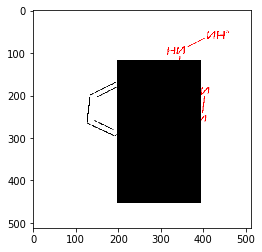

0番目の画像のラベル y[:,0]: [[0. 1.]
 [0. 1.]]


In [8]:
train_datagen = my_generator.MyImageDataGenerator(**args.my_IDG_options)
# 同じラベルのlist:[train_ys, train_ys]を各タスクのラベルにする
train_gen_multi_output = get_train_valid_test.generator_multi_output_wrapper(train_datagen, train_Xs*255., [train_ys, train_ys], args.batch_size)

plain_datagen = ImageDataGenerator(rescale=args.my_IDG_options['rescale'])
# 同じラベルのlist:[valid_ys, valid_ys]を各タスクのラベルにする
valid_gen_multi_output = get_train_valid_test.generator_multi_output_wrapper(plain_datagen, valid_Xs*255., [valid_ys, valid_ys], args.batch_size
                                                                             , is_shuffle=False)
d_cls.train_gen = train_gen_multi_output
d_cls.valid_gen = valid_gen_multi_output

# ラベルをマルチにしたImageDataGeneratorの画像確認
x,y = check_gen(d_cls.train_gen)

print(f"0番目の画像のラベル y[:,0]: {y[:,0]}")

#### model

In [9]:
#### model ####
if args.model_path is None:
    if args.trainable != 'all':
        args.trainable = int(args.trainable)
    model, orig_model = define_model.get_fine_tuning_model(args.output_dir, args.img_rows, args.img_cols, args.channels, len(args.classes)
                                                           , args.choice_model, args.trainable
                                                           , fcs=args.fcs, drop=args.drop
                                                           , is_add_batchnorm=args.is_add_batchnorm
                                                           , l2_rate=args.l2_rate
                                                           , activation=args.activation
                                                           , gpu_count=len(args.gpus.split(','))
                                                           , skip_bn=args.is_skip_bn
                                                           , is_multitask=args.is_multitask, multitask_pred_n_node=args.multitask_pred_n_node
                                                          )
else:
    model = keras.models.load_model(args.model_path, compile=False)

----- model_param -----
output_dir = output/multitask_categorical_crossentropy_test
img_rows img_cols channels = 512 512 3
num_classes = 2
choice_model trainable = InceptionV3 249
fcs = [1024, 512, 256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
is_multitask = True


/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 1024 0.5 True he_normal 0.0001
dence dropout is_add_batchnorm kernel_initializer l2_rate = 512 0.5 True he_normal 0.0001
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
dence dropout is_add_batchnorm kernel_initializer l2_rate = 1024 0.5 True he_normal 0.0001
dence dropout is_add_batchnorm kernel_initializer l2_rate = 512 0.5 True he_normal 0.0001
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//3, verbose=1))
    return cb

#### ImageDataGeneratorのgenaratorからtrain

---- choice_optim = adamax ----
adamax_lr adamax_decay beta_1 beta_2 = 0.0001 1e-06 0.9 0.999
Epoch 1/5
10/10 [==============================] - 42s 4s/step - loss: 1.9367 - task0_pred_loss: 0.6930 - task1_pred_loss: 0.6930 - task0_pred_acc: 0.5000 - task1_pred_acc: 0.4200 - val_loss: 1.9339 - val_task0_pred_loss: 0.6931 - val_task1_pred_loss: 0.6931 - val_task0_pred_acc: 0.5250 - val_task1_pred_acc: 0.5250
Epoch 2/5
10/10 [==============================] - 10s 1s/step - loss: 1.9334 - task0_pred_loss: 0.6929 - task1_pred_loss: 0.6935 - task0_pred_acc: 0.5400 - task1_pred_acc: 0.4200 - val_loss: 1.9327 - val_task0_pred_loss: 0.6932 - val_task1_pred_loss: 0.6932 - val_task0_pred_acc: 0.5000 - val_task1_pred_acc: 0.4750
Epoch 3/5
10/10 [==============================] - 10s 1s/step - loss: 1.9314 - task0_pred_loss: 0.6924 - task1_pred_loss: 0.6929 - task0_pred_acc: 0.5800 - task1_pred_acc: 0.5200 - val_loss: 1.9322 - val_task0_pred_loss: 0.6932 - val_task1_pred_loss: 0.6932 - val_task0_p

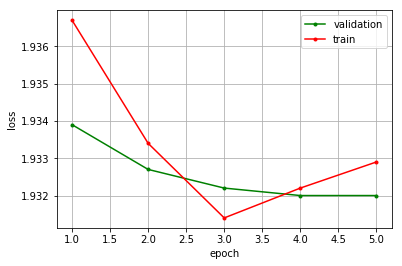

<Figure size 432x288 with 0 Axes>

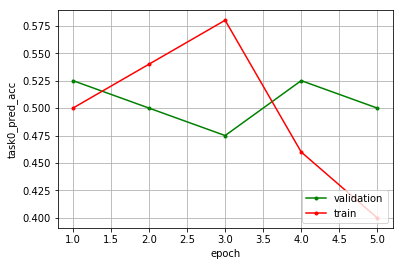

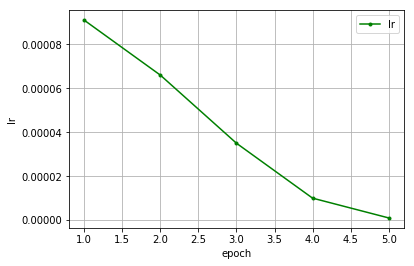

<Figure size 432x288 with 0 Axes>

In [12]:
#### train ####
optim = define_model.get_optimizer(args.choice_optim, lr=args.lr, decay=args.decay, momentum=args.momentum)
model.compile(loss=args.loss, optimizer=optim, metrics=args.metrics)
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = util.file_count(args.train_data_dir, r'.png')//args.batch_size,
    epochs = args.num_epoch,
    validation_data = d_cls.valid_gen,
    validation_steps = util.file_count(args.validation_data_dir, r'.png')//args.batch_size,
    verbose = 1,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    #class_weight=classWeight, # ラベル数少ないデータの重みを大きくする
    callbacks = get_cb(args.output_dir, args.num_epoch))
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(args.output_dir, os.path.join(args.output_dir, 'tsv_logger.tsv'), acc_metric='task0_pred_acc')

#### predict

In [13]:
model = keras.models.load_model(os.path.join(args.output_dir, 'finetuning.h5'), compile=False)

In [14]:
X,y = next(d_cls.train_gen)
#X,y = next(d_cls.valid_gen)
display(f"y: {y}, {np.array(y).shape}")

pred_y = model.predict(X)
for p in pred_y:
    display(f"p: {p}, {p.shape}")

'y: [array([[1., 0.],\n       [1., 0.],\n       [0., 1.],\n       [0., 1.],\n       [0., 1.]]), array([[1., 0.],\n       [1., 0.],\n       [0., 1.],\n       [0., 1.],\n       [0., 1.]])], (2, 5, 2)'

'p: [[0.50032413 0.49967593]\n [0.5004956  0.49950436]\n [0.50059885 0.49940115]\n [0.5003207  0.49967933]\n [0.5004372  0.4995628 ]], (5, 2)'

'p: [[0.5002766  0.49972337]\n [0.5001478  0.49985218]\n [0.5002192  0.4997808 ]\n [0.49995536 0.50004464]\n [0.5000994  0.49990058]], (5, 2)'

#### set predict

In [7]:
valid_Xs, valid_ys, valid_paths = base_dataset.load_my_data(args.validation_data_dir
                                                            , classes=args.classes
                                                            , img_height=args.img_cols, img_width=args.img_rows, channel=args.channels
                                                            , is_pytorch=False)
d_cls.X_test = valid_Xs
d_cls.y_test = np.array([valid_ys, valid_ys]) # マルチタスクの次元に変更(shapeはタスク数,ファイル数,各タスクのクラス数。binaryならタスク数,ファイル数のみ)
test_files = valid_paths

classes: ['negative', 'positive']
[INFO] data matrix: 40 images (245.76MB)


In [8]:
print(d_cls.y_test)
print(d_cls.y_test.shape)

[[[0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [0. 1.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]]]
(2, 40, 2)


y_pred.shape: (2, 40, 2)
y_test_list:
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])]
y_pred_list:
[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

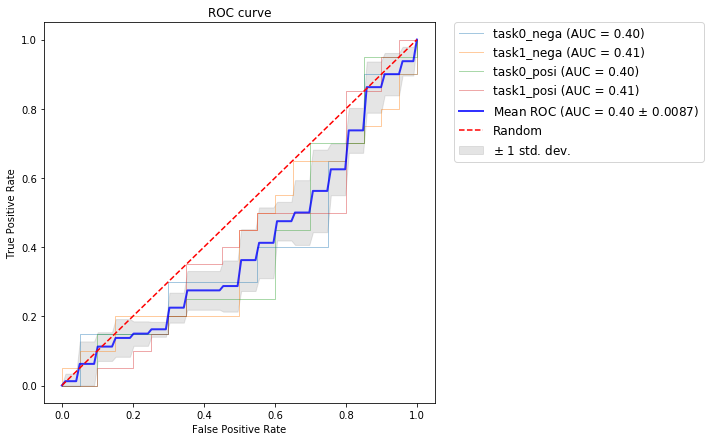

task0_nega_roc_auc: 0.48048455382336963
task1_nega_roc_auc: 0.5031333187943179
task0_posi_roc_auc: 0.45378372005674633
task1_posi_roc_auc: 0.4508306295412325
Average precision score, micro-averaged over all classes: 0.48367805


<Figure size 432x288 with 0 Axes>

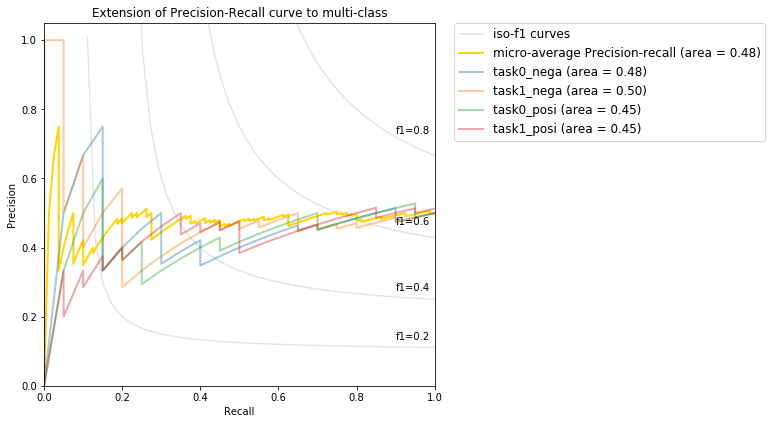

In [47]:
# -------- 推論 --------
model = keras.models.load_model(os.path.join(args.output_dir, 'finetuning.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(args.output_dir, 'predict/test')
os.makedirs(out_predict_dir, exist_ok=True)

# multi_label_modelのpredict
y_test_list, y_pred_list = multi_predict.branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)# , TTA='flip'

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_test_list, y_pred_list, out_predict_dir, is_show=False)

# roc/pr curve描画するために平坦化
y_test_list = [flatten for inner in y_test_list for flatten in inner]
y_pred_list = [flatten for inner in y_pred_list for flatten in inner]
task_name_list = ['task0_nega', 'task1_nega', 'task0_posi', 'task1_posi']

# predict y 確認
print(f"y_test_list:\n{y_test_list}")
print(f"y_pred_list:\n{y_pred_list}")

# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list, task_name_list=task_name_list)

# -------- PR_area --------
pr_curve.plot_each_class_PR(len(task_name_list), y_test_list, y_pred_list, os.path.join(out_predict_dir, 'PR_curve.png'), task_name_list=task_name_list)

In [40]:
print(d_cls.y_test[:,0].ndim)
t = d_cls.y_test[:,0]
print(t)
print(t[0])
print(t[1][1])

2
[[0. 1.]
 [0. 1.]]
[0. 1.]
1.0


y_true:
[[0. 1.]
 [0. 1.]], (2, 2)



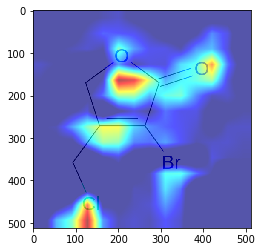

In [67]:
# 確認用。1件だけgradcam実行

out_grad_cam_dir = os.path.join(args.output_dir, 'grad_cam/test')
out_grad_cam_plus_dir = os.path.join(args.output_dir, 'grad_cam_plus/test')

for i,x in tqdm(enumerate(d_cls.X_test)):
    
    # 50枚ごとにモデル再ロード
    if i % 50 == 0:
        K.clear_session() # セッションのクリア
        K.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる

        # multilabel model
        model = keras.models.load_model(os.path.join(args.output_dir, 'finetuning.h5'), compile=False)
    
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0

    # ファイル名
    input_img_name = os.path.basename(test_files[i])
    #print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_test[:,i]
    print(f"y_true:\n{y_true}, {y_true.shape}")

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.branch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, args.layer_name, is_gradcam_plus=False)
    #grad_cam_plus_img = grad_cam.branch_multi_grad_cam(model, out_grad_cam_plus_dir, input_img_name, x, y_true, args.layer_name, is_gradcam_plus=True)
    break
    
# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()
#plt.imshow(grad_cam_plus_img)
#plt.show()

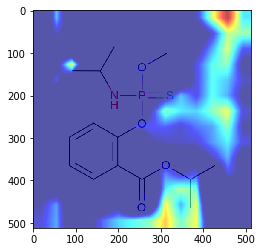

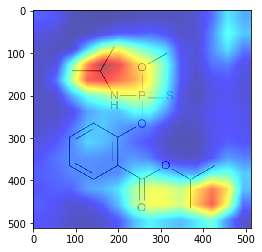

In [68]:
out_grad_cam_dir = os.path.join(args.output_dir, 'grad_cam/test')
out_grad_cam_plus_dir = os.path.join(args.output_dir, 'grad_cam_plus/test')

for i,x in tqdm(enumerate(d_cls.X_test)):
    
    # 50枚ごとにモデル再ロード
    if i % 50 == 0:
        K.clear_session() # セッションのクリア
        K.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる

        # multilabel model
        model = keras.models.load_model(os.path.join(args.output_dir, 'finetuning.h5'), compile=False)
    
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0

    # ファイル名
    input_img_name = os.path.basename(test_files[i])
    #print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_test[:,i]

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.branch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, args.layer_name, is_gradcam_plus=False)
    grad_cam_plus_img = grad_cam.branch_multi_grad_cam(model, out_grad_cam_plus_dir, input_img_name, x, y_true, args.layer_name, is_gradcam_plus=True)
    
# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()
plt.imshow(grad_cam_plus_img)
plt.show()

In [32]:
# GradCam.xlsx作成
sheet_name = 'GradCam'
xlsxwriter_util.multitask_gradcam_xlsx_onesheet_label_prob(args.output_dir+f'/{sheet_name}_test.xlsx' # 作成するエクセルのパス
                                                           , os.path.join(args.output_dir, 'grad_cam/test') # エクセルに貼り付けるGradCamかけた画像のディレクトリ
                                                           , ['task0', 'task1']
                                                           , args.classes
                                                           , sheet_name # 作成するエクセルのシート名
                                                           , x_scale=0.28, y_scale=0.28
                                                          )
# GradCam++.xlsx作成
sheet_name = 'GradCam++'
xlsxwriter_util.multitask_gradcam_xlsx_onesheet_label_prob(args.output_dir+f'/{sheet_name}_test.xlsx' # 作成するエクセルのパス
                                                           , os.path.join(args.output_dir, 'grad_cam_plus/test') # エクセルに貼り付けるGradCamかけた画像のディレクトリ
                                                           , ['task0', 'task1']
                                                           , args.classes 
                                                           , sheet_name # 作成するエクセルのシート名
                                                           , x_scale=0.28, y_scale=0.28
                                                          )

# オリジナル画像だけxlsxも作成
xlsxwriter_util.origimgs_xlsx_onesheet(args.output_dir+'/orig_test.xlsx' # 作成するエクセルのパス
                                       , '/gpfsx01/home/aaa00162/jupyterhub/notebook/H3-057/OrigData/skynet_H3-057/Ames_oedepict' # エクセルに貼り付ける画像のディレクトリ
                                       , os.path.join(args.output_dir, 'grad_cam/test') # GradCamかけた画像ディレクトリ
                                       , args.classes
                                       , is_pred_col=False
                                       , x_scale=0.27, y_scale=0.27
                                      )

output/multitask_categorical_crossentropy_test/GradCam_test.xlsx
output/multitask_categorical_crossentropy_test/GradCam++_test.xlsx
output/multitask_categorical_crossentropy_test/orig_test.xlsx


In [17]:
import glob
li = ["task0_0.jpg", "task0_1.jpg"]
l_in = [s for s in li if '_1' in s]
l_in

['task0_1.jpg']